In [478]:
import os

import numpy as np 

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std
from astropy.table import Table
from astropy.modeling import models, fitting

from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture

In [69]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec

# TODO

- [ ] Find out the mean pixel value of an LCBG in the ACS images
    - We need this for clipping the catalog without removing these objects
    - Do we already know where the LCBGs are or do we use spectra data to find them?
    
    
- [ ] Compare the output catalog to catalogs that are already out there
    - There might be a catalog in the fits files?


- [ ] Check if we need to mask bright stars
    - If so we need to refer to a catalog of stars
    
    
- [ ] Look up what the flux and mag columns in the sources table mean



- Do we clip negative data values or do we add the min for the data to the data (sale it up)?  

# Local Paths (NB Inputs)

In [4]:
abell370_f435w_epoch2_drz_file = "/Users/rgeda/project/data/lcbg/hlsp_frontier_hst_acs-30mas_abell370/hlsp_frontier_hst_acs-30mas_abell370-hffpar_f435w_v1.0-epoch2_drz.fits"

In [512]:
input_data_path = abell370_f435w_epoch2_drz_file

output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

print("Output: ", output_path)

Output:  hlsp_frontier_hst_acs-30mas_abell370-hffpar_f435w_v1.0-epoch2_drz_catalog.csv


# Load Data

In [13]:
hdul = fits.open(abell370_f435w_epoch2_drz_file)
hdu = hdul[0]

In [14]:
data = hdu.data
header = hdu.header

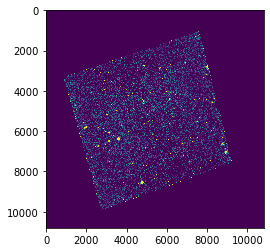

In [17]:
plt.imshow(data, vmin=0, vmax=2.9534784e-05*90)

# Estimate Mean Noise

Mean of the image 

2.9534784e-05

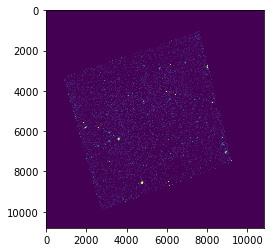

In [44]:
subsection = data 
plt.imshow(subsection, vmin=0, vmax=2.9534784e-05*350)
subsection.mean()

Zoom into image croping out zero and nan values

4.147323e-05

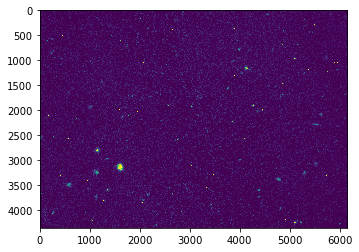

In [81]:
subsection = data[3250:7600, 2000:8150]
plt.imshow(subsection, vmin=0, vmax=2.9534784e-05*350)
subsection.mean()

Zoom into dark region of the image and find noise

4.607869e-05

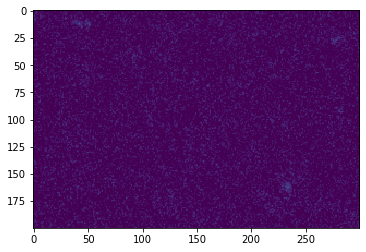

In [45]:
subsection = data[8500:8700, 2700:3000]
plt.imshow(subsection, vmin=0, vmax=2.9534784e-05*350)
subsection.mean()

In [88]:
mad_std(data)  

0.0

In [405]:
mean_noise = 4.5e-5

# Estimate FWHM

This will be used to estimate the size of the apertures used in the photometry section

In [406]:
def measure_fwhm(image, x, y, box_size, clip_value=None):
    global mean_noise
    
    slice_index = box_size // 2
    
    image = data[x-slice_index:x+slice_index, y-slice_index:y+slice_index] 
    
    if clip_value:
        image = np.clip(image, image.min(), clip_value)
        
    print("Max =", image.max())
    print("Max/mean_noise =", image.max()/mean_noise)


    image_slice = image[slice_index]

    center = image_slice.argmax()
    
    arange = np.arange(image_slice.shape[0])
    model = models.Gaussian1D(amplitude=image.max(), mean=center)
    fit = fitting.LevMarLSQFitter()
    fitted_line = fit(model, arange, image_slice)
    
    center = int(np.round(fitted_line.mean))
    hm = fitted_line(center) / 2.
    x_hm = abs(fitted_line(arange) - hm).argmin()
    fwhm = abs(center - x_hm) * 2

    print("FWHM: ", fwhm)
    print("Center: ", center)

    plt.imshow(np.sqrt(np.clip(image, 0, image.max())), cmap='gray_r')
    plt.axhline(slice_index, label="Flux 1D Slice")
    
    plt.axvline(center, c='g', linestyle="--", label="Center")
    plt.axvline(center - fwhm//2, c='c', linestyle="--", label="FWHM")
    plt.axvline(center + fwhm//2, c='c', linestyle="--")
    
    plt.legend()
    plt.show()

    plt.plot(arange, fitted_line(arange), c='r')
    plt.scatter(arange, image_slice, c='black')
    
    plt.axvline(center, c='g', linestyle="--", label="Center")
    plt.axvline(center - fwhm//2, c='c', linestyle="--", label="FWHM")
    plt.axvline(center + fwhm//2, c='c', linestyle="--")
    
    plt.xlabel("Pixel")
    plt.ylabel("Flux")
    
    plt.legend()
    plt.show()
    
    return fwhm



### Bright star:

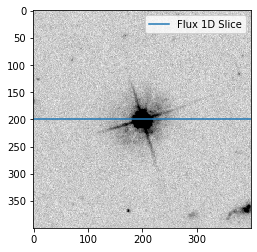

Max = 21.091347
Max/mean_noise = 468696.5942382812
FWHM:  4
Center:  100


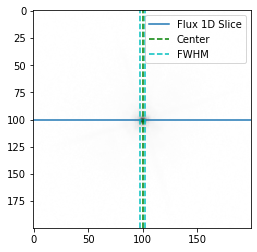

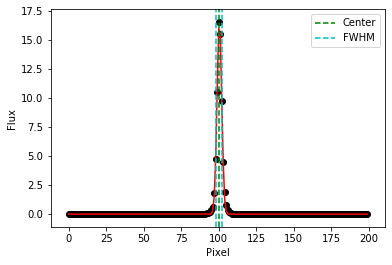

In [483]:
x = 6050
y = 3146
slice_index = 200
image = data[x-slice_index:x+slice_index, y-slice_index:y+slice_index]
plt.imshow(image, vmax=mean_noise*200, cmap='gray_r')
plt.axhline(slice_index, label="Flux 1D Slice")
plt.legend()
plt.show()

measure_fwhm(data, 6050, 3146, 200);

Max = 0.0135
Max/mean_noise = 300.0000077817175
FWHM:  42
Center:  102


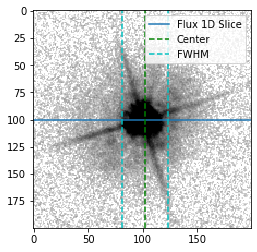

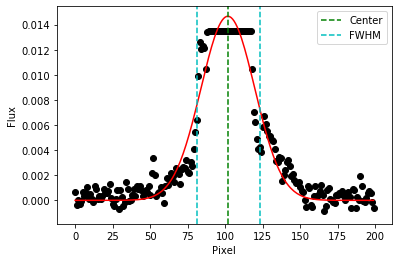

In [482]:
measure_fwhm(data, 6050, 3146, 200, clip_value=mean_noise*300);

### Dim star:

Max = 0.0129728345
Max/mean_noise = 288.2852115564876
FWHM:  4
Center:  14


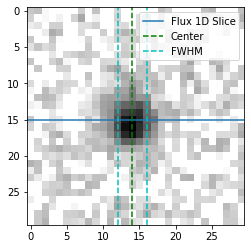

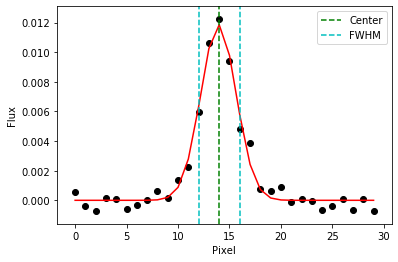

In [481]:
measure_fwhm(data, 5711, 7048, 30);

### Measure FWHM for wide galaxy

We measure by taking a slice right above the core

Max = 0.027
Max/mean_noise = 600.000015563435
FWHM:  62
Center:  161


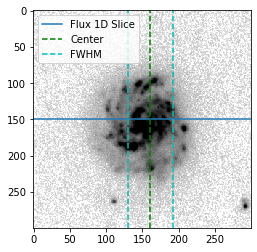

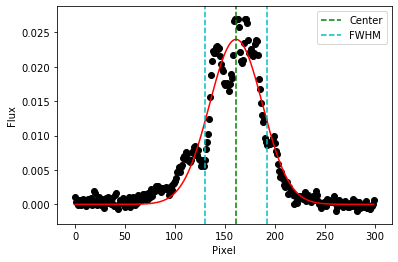

In [479]:
measure_fwhm(data, 6377, 3595, 300, mean_noise*600);

Max = 0.07395289
Max/mean_noise = 1643.3975762791104
FWHM:  66
Center:  149


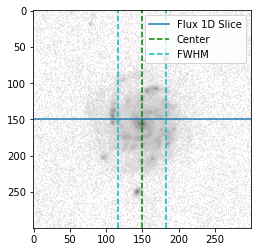

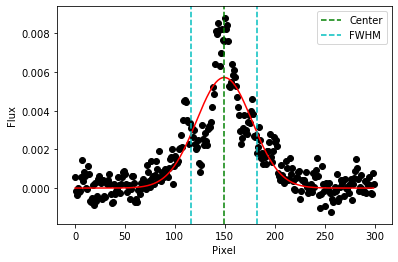

In [480]:
measure_fwhm(data, 6479, 3124, 300);

# Aperture Photometry

### Select Image

In [490]:
image = data
#image = data[6200:6600, 2700+800:4000]
#image = data[6000:7000, 2700:4000] 
#image = data[5900:6200, 2950:3300] 

Subtract estimated background and clip out negative values

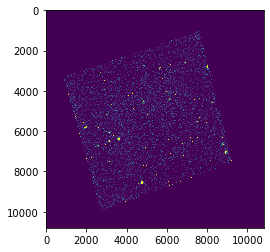

In [492]:
image = image - mean_noise
image = np.clip(image, 0, image.max())

plt.imshow(image, vmax=mean_noise*100)

### Make Catalog

In [517]:
fwhm = 12.
threshold = 100*mean_noise

daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)  

sources = daofind(image)

assert sources is not None, "sources is None"

print("{} objects found".format(len(sources)))

2332 objects found


### Make Apertures

In [518]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=fwhm)   

### Do Photometry

In [519]:
phot_table = aperture_photometry(image, apertures)  

print(phot_table) 

 id       xcenter            ycenter           aperture_sum   
            pix                pix                            
---- ------------------ ------------------ -------------------
   1  7507.164579475982 1076.3472615205937  2.9466726488136468
   2  7582.209897856621 1083.4255997392036 0.14819885784641978
   3  7330.148406766949 1131.4241177482002 0.21335428781152926
   4  7270.963835810397 1152.6183958309423  0.2125946074744987
   5  7600.089668773877  1162.253626184575  0.2709612866198274
   6  7195.097966362596 1180.7582305663184 0.23924962513993187
   7  7588.152469039182 1188.1478100904028  0.5261876484226478
   8  7597.936174678438 1191.0227886967539  0.5349906998767404
   9  7109.403756274077  1211.725668411012  0.2565911183695436
  10  6907.263281094216 1278.2481584699158  0.1927506095834917
 ...                ...                ...                 ...
2323 3008.7362881994663  9557.078178899248  0.1259232086917017
2324  3283.425049370239  9637.818054988784 0.1318940846

### Plot

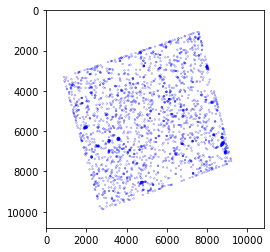

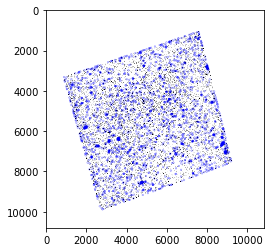

In [520]:
plt.imshow(np.zeros_like(image), cmap='gray_r')
apertures.plot(color='blue', lw=1.5, alpha=0.5)


plt.show()

plt.imshow(image, cmap='gray_r', vmax=mean_noise*50)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

# Save Catalog to File

In [521]:
output_table = Table(sources)
output_table.add_column(phot_table['aperture_sum'])

In [522]:
output_table.write(output_path, format="ascii.csv", overwrite=True)